In [2]:
import torch
from IPython.display import SVG
from sknetwork.data import house, bow_tie, karate_club, miserables, painters, hourglass, star_wars, movie_actor
from sknetwork.visualization import svg_graph, svg_bigraph
import networkx as nx
import numpy as np
import scipy.sparse as sp
# Import graph embeddings framework
from graph_embeddings.models.L2Model import L2Model
from graph_embeddings.utils.trainer import Trainer
from graph_embeddings.utils.loss import LogisticLoss, HingeLoss
from graph_embeddings.utils.logger import JSONLogger


# %matplotlib widget
from matplotlib import pyplot as plt

# Painters Graph (sknetwork)

## Load graph
Load Painters graph

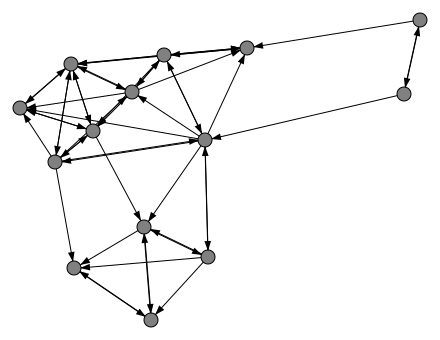

In [3]:
graph = painters(metadata=True)
adjacency = graph.adjacency
names = graph.names
position = graph.position

# Visualization
image = svg_graph(adjacency, position)
SVG(image)

Load into a networkx graph to calculate some stats

In [4]:
# Create an empty undirected graph
G = nx.Graph()

# Add edges from the sparse matrix
rows, cols = sp.find(adjacency)[:2]  # Get the non-zero indices
for row, col in zip(rows, cols):
    if row != col:
        G.add_edge(row, col)

## Calculate graph statistics

Number of nodes: 14
Number of edges: 25.0
Average degree: 3.5714285714285716
Graph density: 0.37362637362637363
Number of connected components: 1


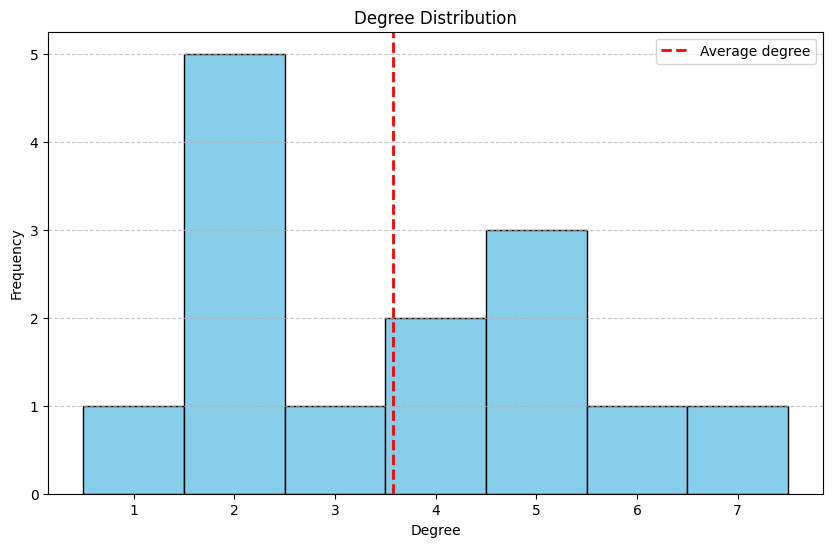

In [5]:
# Print graph statistics
print('Number of nodes:', adjacency.shape[0])

# Calculate the number of edges
# For an undirected graph, each edge is counted twice in an adjacency matrix
num_edges = adjacency.todense().sum()/2

# Calculate the average degree
# Since each edge is counted twice in the sum, divide by the number of nodes to get the average degree
average_degree = adjacency.todense().sum() / adjacency.shape[0]

print(f'Number of edges: {num_edges}')
print(f'Average degree: {average_degree}')
print('Graph density:', nx.density(G))
print('Number of connected components:', nx.number_connected_components(G))


degree = adjacency.dot(torch.ones(adjacency.shape[0], dtype=int))
# Plotting degree distribution with enhanced aesthetics
plt.figure(figsize=(10, 6))

# Custom bin edges for the histogram
bin_edges = np.arange(0.5, degree.max() + 1.5, 1)

# Plot histogram with customizations
plt.hist(degree, bins=bin_edges, color='skyblue', edgecolor='black')
# plot average degree as a vertical line
plt.axvline(degree.mean(), color='r', linestyle='dashed', linewidth=2, label='Average degree')

# Customizing the plot
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.xticks(np.arange(1, degree.max() + 1, 1))  # Set x-axis ticks to match the degree values
plt.legend()

# Adding a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

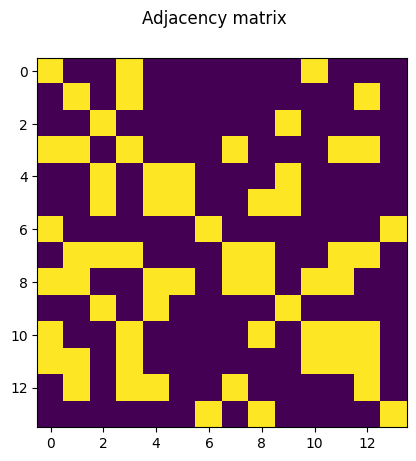

In [6]:
plt.close()
# convert adjacency matrix to tensor
adj = torch.tensor(adjacency.todense(), dtype=torch.float32)
adj = adj + torch.eye(adj.shape[0])
# 
plt.imshow(adj.detach())
plt.suptitle('Adjacency matrix')
plt.show()

## GraphEmbeddings

Train a graph embedding model using GraphEmbeddings framework and $rank = 3$ ($2$ seems to not be enough to capture the graph structure)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Train model
loss_fn = HingeLoss()
learning_rate = 1e-1
num_epochs = 10000
rank = 3

# Initialize the trainer
trainer = Trainer(adj=adj, model_class=L2Model, loss_fn=loss_fn, model_init='random',
                  threshold=10e-5, num_epochs=num_epochs, save_ckpt='results/model.pt', # 'lbfgs', 'adam', 'sgd
                  device=device, loggers=[])#, wandb])


save_path = f'./2_model_paintings_rank{rank}.pt'
trainer.train(rank = rank, lr=learning_rate, save_path=save_path)

L2Model rank=3, loss=0.0 frob_err@700=nan:   7%|▋         | 680/10000 [00:01<00:20, 454.01it/s]   


Full reconstruction at epoch 700 with rank 3


L2Model()

In [21]:
# load saved model
path = f'./2_model_paintings_rank{rank}_FR.pt'
# path = f'./model_paintings_rank{rank}_FR.pt'
X,Y, beta = torch.load(path)
X, Y, beta = X.detach(), Y.detach(), beta.detach()

print(f"The radius of the circle is: {beta.item()}")


The radius of the circle is: 7.003762722015381


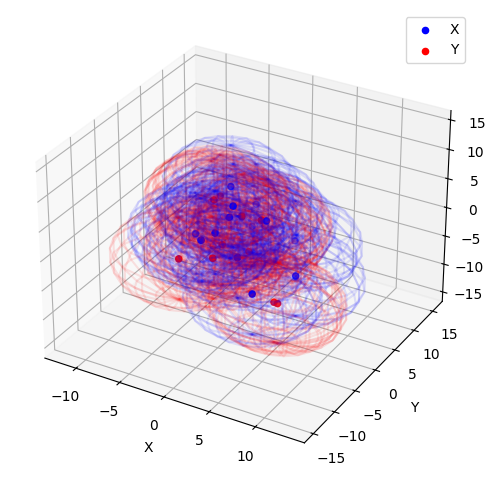

In [23]:
# %matplotlib widget

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(X[:,0], X[:,1], X[:,2], color='b', label='X')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], color='r', label='Y')

# Function to draw a sphere
def draw_sphere(x, y, z, radius, color='b', alpha=0.1):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    sphere_x = x + radius * np.cos(u) * np.sin(v)
    sphere_y = y + radius * np.sin(u) * np.sin(v)
    sphere_z = z + radius * np.cos(v)
    ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color=color, alpha=alpha)

# Draw spheres around points in X
for point in X:
    draw_sphere(point[0], point[1], point[2], beta, color='b')

# Draw spheres around points in Y
for point in Y:
    draw_sphere(point[0], point[1], point[2], beta, color='r')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()


# Cora (Just a slice)

Load cora and slice it. We do this to be able to represent the graph embeddings in 2D.

In [101]:
# load cora adjaceny matrix
adj = torch.load(f'../data/adj_matrices/Cora.pt')
# Add 1 to the diagonal
adj = adj + torch.eye(adj.shape[0])
adj = adj[:100, :100]

In [102]:
G = nx.Graph()

# Add edges from the sparse matrix
rows, cols = sp.find(adj)[:2]  # Get the non-zero indices
for row, col in zip(rows, cols):
    if row != col:
        G.add_edge(row, col)

## Statistics

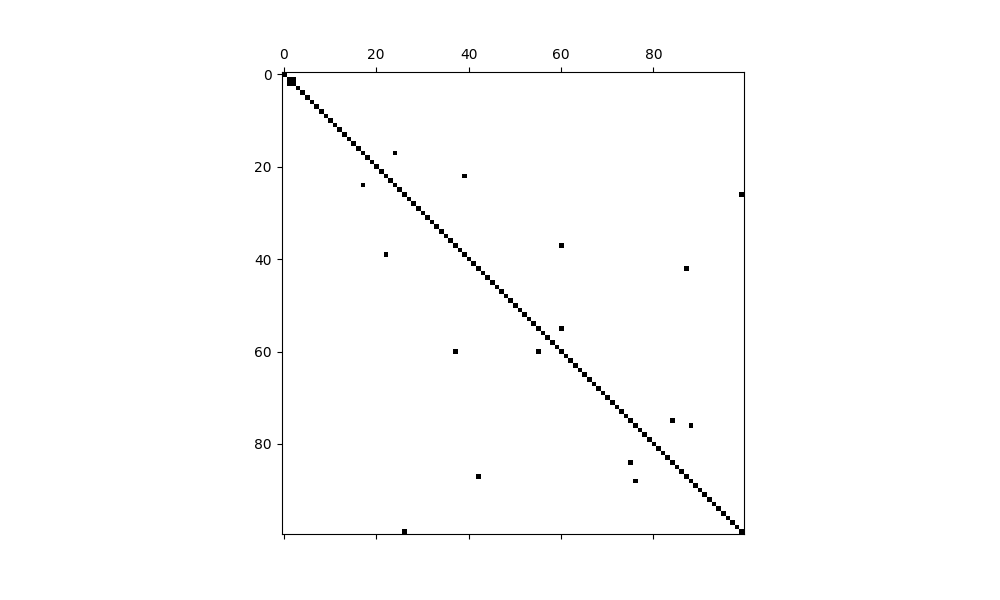

In [103]:
plt.clf()
plt.spy(adj.detach())
plt.show()

Number of nodes: 100
Number of edges: 9.0
Average degree: 0.18000000715255737
Graph density: 0.0661764705882353
Number of connected components: 8


Text(0.5, 0.98, 'Degree Distribution')

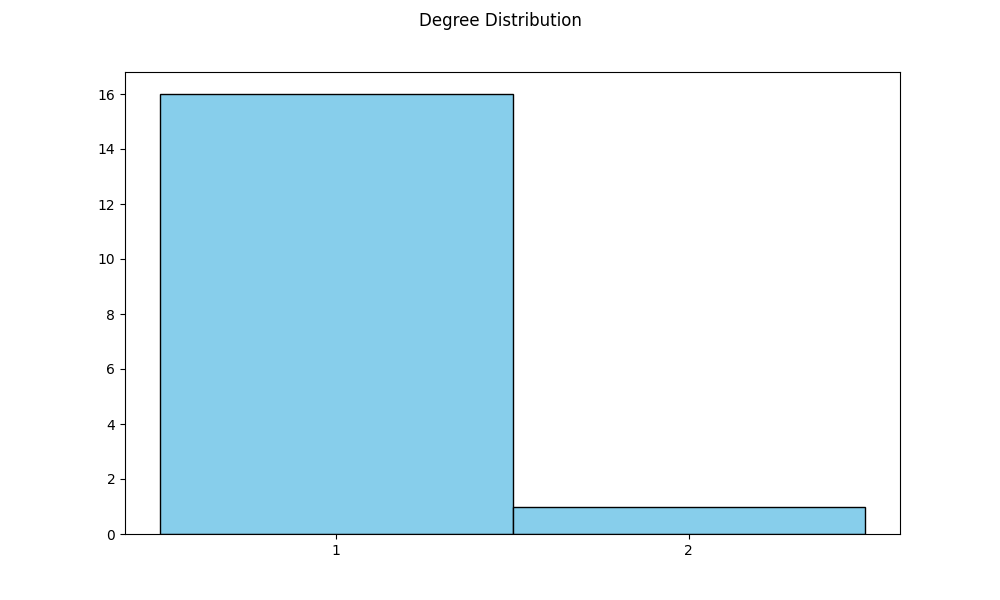

In [104]:

adj_ = adj - torch.eye(adj.shape[0])
# Print graph statistics
print('Number of nodes:', adj.shape[0])


# Subtract the identity for edge stats
adj_ = adj - torch.eye(adj.shape[0])
# Calculate the number of edges
# For an undirected graph, each edge is counted twice in an adjacency matrix
num_edges = adj_.sum() /2

# Calculate the average degree
# Since each edge is counted twice in the sum, divide by the number of nodes to get the average degree
average_degree = adj_.sum() / adj_.shape[0]

print(f'Number of edges: {num_edges}')
print(f'Average degree: {average_degree}')
print('Graph density:', nx.density(G))
print('Number of connected components:', nx.number_connected_components(G))



# Plot degree distribution
degree = adj_.sum(dim=1)
# Plotting degree distribution with enhanced aesthetics
plt.figure(figsize=(10, 6))

# Custom bin edges for the histogram
bin_edges = np.arange(0.5, degree.max() + 1.5, 1)

# Plot histogram with customizations
plt.hist(degree, bins=bin_edges, color='skyblue', edgecolor='black')
# Ticks 
plt.xticks(np.arange(1, degree.max() + 1, 1))  # Set x-axis ticks to match the degree values
plt.suptitle('Degree Distribution')


## Graph Embeddings

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Train model
# loss_fn = HingeLoss()
loss_fn = LogisticLoss()
learning_rate = 1e-2
num_epochs = 40000
rank = 2

# Initialize the trainer
trainer = Trainer(adj=adj, model_class=L2Model, loss_fn=loss_fn, model_init='random',
                  threshold=10e-5, num_epochs=num_epochs, save_ckpt='results/model.pt', # 'lbfgs', 'adam', 'sgd
                  device=device, loggers=[])#, wandb])


save_path = f'/Users/alf/Repos/GraphEmbeddings/results/models/model_cora100_rank{rank}.pt'
trainer.train(rank = rank, lr=learning_rate, save_path=save_path)

L2Model rank=2, loss=18.8 frob_err@39900=0.3350: 100%|██████████| 40000/40000 [01:26<00:00, 462.64it/s]


PermissionError: [Errno 13] Permission denied: '/Users'

## Explore embeddings

In [9]:
# Load cora dataset
X, Y, beta = torch.load('/Users/alf/Repos/GraphEmbeddings/results/models/model_cora100_rank2_FR.pt', map_location=torch.device('cpu'))
X, Y, beta = X.detach(), Y.detach(), beta.detach()

In [10]:
print("Embedding shape X:", X.shape)
print("Embedding shape Y:", Y.shape)
print("Embedding radius:", beta.item())

Embedding shape X: torch.Size([100, 2])
Embedding shape Y: torch.Size([100, 2])
Embedding radius: 2.9145381450653076


Plot the embeddings in 2D with their radius

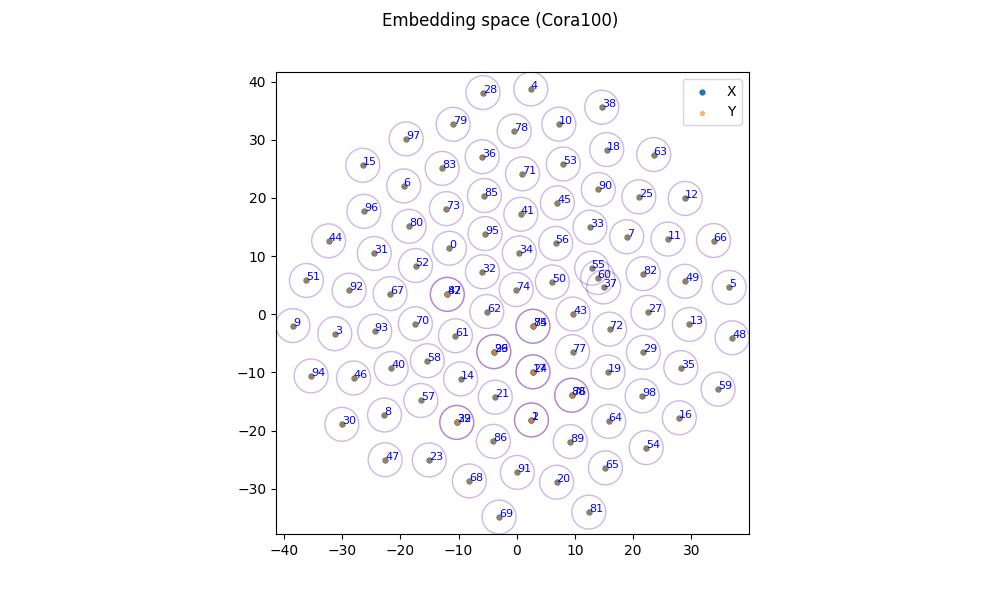

In [11]:
# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X[:,0].numpy(), X[:,1].numpy(), label='X', s=12)
plt.scatter(Y[:,0].numpy(), Y[:,1].numpy(), label='Y', s=8, alpha=0.5)

# Add number to each point
for i in range(X.shape[0]):
    plt.text(X[i,0], X[i,1], str(i), fontsize=8, color='blue')


# plot circle around each point with radius beta
for i in range(X.shape[0]):
    circle = plt.Circle((X[i,0], X[i,1]), beta, color='blue', fill=False, alpha=0.2)

    plt.gcf().gca().add_artist(circle)

for i in range(Y.shape[0]):
    circle = plt.Circle((Y[i,0], Y[i,1]), beta, color='red', fill=False, alpha=0.1)

    plt.gcf().gca().add_artist(circle)

# x, y limits of the plot
x_min, x_max = X[:,0].min().item(), X[:,0].max().item()
y_min, y_max = X[:,1].min().item(), X[:,1].max().item()

plt.xlim(x_min-beta, x_max+beta)
plt.ylim(y_min-beta, y_max+beta)

# Make plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle('Embedding space (Cora100)')
plt.legend()
plt.show()



## Apply KNN

In [27]:
# Make KNN clustering
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

# stack embeddings
stacked_embeddings = torch.cat([X, Y], dim=0)

# KNN clustering
knn = NearestNeighbors(n_neighbors=5, radius=beta.item(), metric='euclidean')
knn.fit(stacked_embeddings)
distances, indices = knn.kneighbors(stacked_embeddings)

# Triangles toy graph

In [105]:
toy_data_size=15

/Users/alf/.virtualenvs/sc/lib/python3.11/site-packages/scipy/sparse/_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


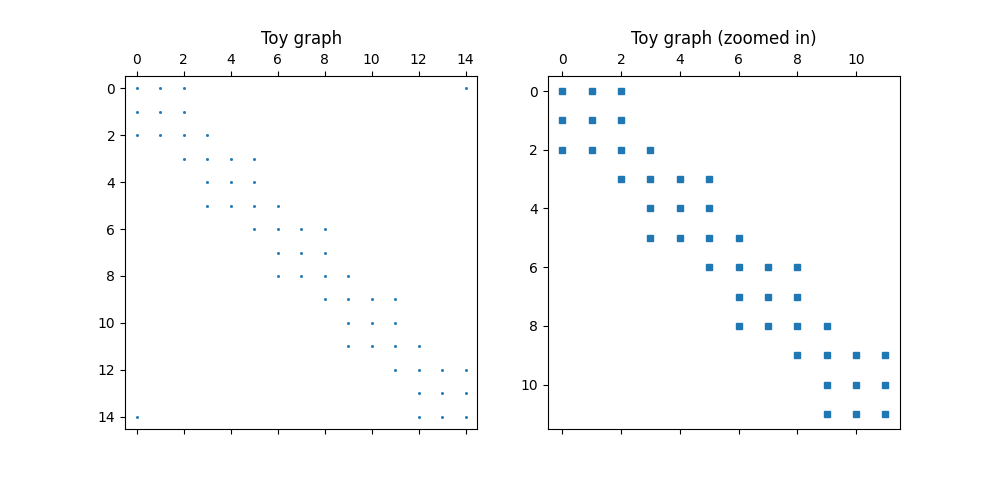

In [106]:
# Create toy graph. Source: https://github.com/schariya/exact-embeddings/blob/master/ExactEmbeddings.ipynb

import scipy as sp
import scipy.sparse, scipy.io, scipy.optimize
# Create the toy graph with n_tri triangles
def tri_path(n_tri, cycle=True, self_loops=True):
    tri_block = sp.sparse.coo_matrix([[0,1,1],[1,0,1],[1,1,0]])
    mat = sp.sparse.block_diag((tri_block,)*n_tri)
    diag = np.tile([0,0,1], n_tri)[:-1]
    mat += sp.sparse.diags([diag, diag], [-1,1])
    if cycle:
        mat[0,-1] = 1
        mat[-1,0] = 1
    if self_loops:
        mat += sp.sparse.identity(n_tri*3)
    return mat
adj_toy = tri_path(int(toy_data_size/3), cycle=True, self_loops=True)

# convert to tensor dense
adj_toy = torch.tensor(adj_toy.todense(), dtype=torch.float32)


G_toy = nx.Graph()

# Add edges from the sparse matrix
rows, cols = scipy.sparse.find(adj_toy)[:2]  # Get the non-zero indices
for row, col in zip(rows, cols):
    if row != col:
        G_toy.add_edge(row, col)

# Plot the adjacency matrix side by side
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title('Toy graph')
plt.spy(adj_toy, markersize=1) 
plt.subplot(122)
plt.title('Toy graph (zoomed in)')
plt.spy(adj_toy[:12,:][:,:12], markersize=5)
plt.show()

Plot the toy graph with networkx

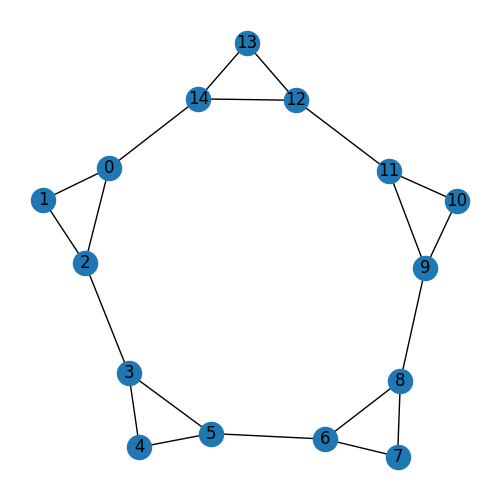

In [110]:
  # Plot the graph
plt.figure(figsize=(5, 5))
nx.draw(G_toy, with_labels=True)
plt.title('Toy graph')
plt.show()



Number of nodes: 15
Number of edges: 20.0
Average degree: 2.6666667461395264
Graph density: 0.19047619047619047
Number of connected components: 1


Text(0.5, 0.98, 'Degree Distribution')

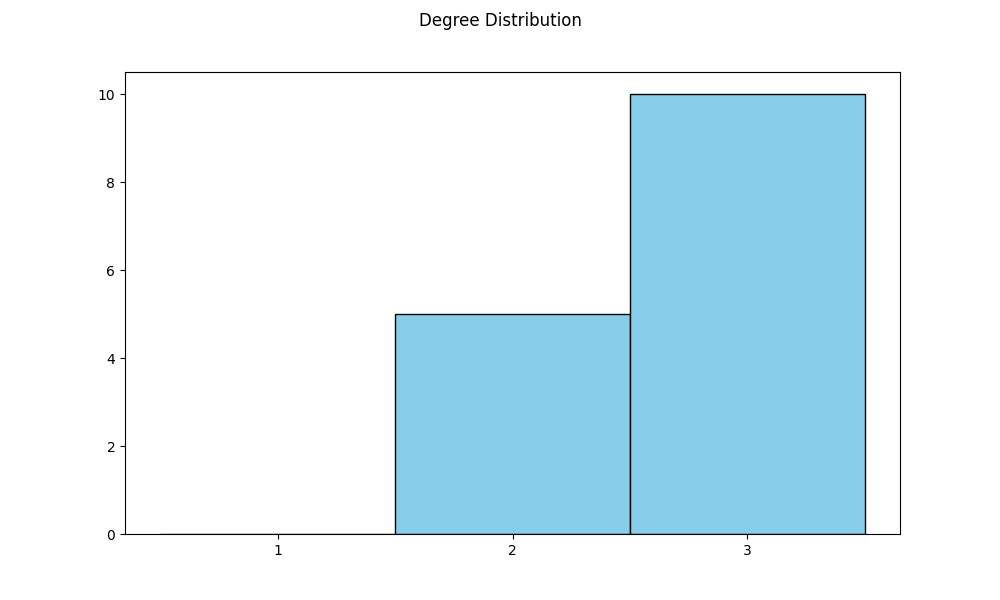

In [94]:

# Print graph statistics
print('Number of nodes:', adj_toy.shape[0])

# Calculate the number of edges
adj_ = adj_toy - torch.eye(adj_toy.shape[0])
# For an undirected graph, each edge is counted twice in an adjacency matrix
num_edges = adj_.sum() /2

# Calculate the average degree
# Since each edge is counted twice in the sum, divide by the number of nodes to get the average degree
average_degree = adj_.sum() / adj_.shape[0]

print(f'Number of edges: {num_edges}')
print(f'Average degree: {average_degree}')
print('Graph density:', nx.density(G_toy))
print('Number of connected components:', nx.number_connected_components(G_toy))



# Plot degree distribution
degree = adj_.sum(dim=1)
# Plotting degree distribution with enhanced aesthetics
plt.figure(figsize=(10, 6))

# Custom bin edges for the histogram
bin_edges = np.arange(0.5, degree.max() + 1.5, 1)

# Plot histogram with customizations
plt.hist(degree, bins=bin_edges, color='skyblue', edgecolor='black')
# Ticks 
plt.xticks(np.arange(1, degree.max() + 1, 1))  # Set x-axis ticks to match the degree values
plt.suptitle('Degree Distribution')


## Embeddings

In [64]:
JSONLogger.finish()

Logging complete. Data stored in results/GraphEmbeddings/log_c1141a07-f159-43e6-8f7e-9cf1deadd59e.json


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Train model
loss_fn = LogisticLoss()
learning_rate = 1e-2
num_epochs = 40000
rank = 2

# Initialize the trainer
trainer = Trainer(adj=adj_toy, model_class=L2Model, loss_fn=loss_fn, model_init='random',
                  threshold=10e-5, num_epochs=num_epochs, save_ckpt='results/model.pt', # 'lbfgs', 'adam', 'sgd
                  device=device, loggers=[JSONLogger])#, wandb])


save_path = f'/Users/alf/Repos/GraphEmbeddings/results/models/model_toy{toy_data_size}_rank{rank}.pt'
trainer.train(rank = rank, lr=learning_rate, save_path=save_path)

L2Model rank=2, epoch=1802, loss=8.4 Frob. err.: 0.0000:   4%|▍         | 1793/40000 [00:07<02:34, 247.40it/s] 


Full reconstruction at epoch 1802 with rank 2
Logging complete. Data stored in results/GraphEmbeddings/log_3a1268cc-7ef7-45fb-859e-0b4fd9c6c489.json


L2Model()

In [76]:
X_toy, Y_toy, beta_toy = torch.load(f'/Users/alf/Repos/GraphEmbeddings/results/models/model_toy{toy_data_size}_rank{rank}_FR.pt', map_location=torch.device('cpu'))
X_toy, Y_toy, beta_toy = X_toy.detach(), Y_toy.detach(), beta_toy.detach()
print("Embedding shape X:", X_toy.shape)
print("Embedding shape Y:", Y_toy.shape)
print("Embedding radius:", beta_toy.item())

Embedding shape X: torch.Size([15, 2])
Embedding shape Y: torch.Size([15, 2])
Embedding radius: 6.627673625946045


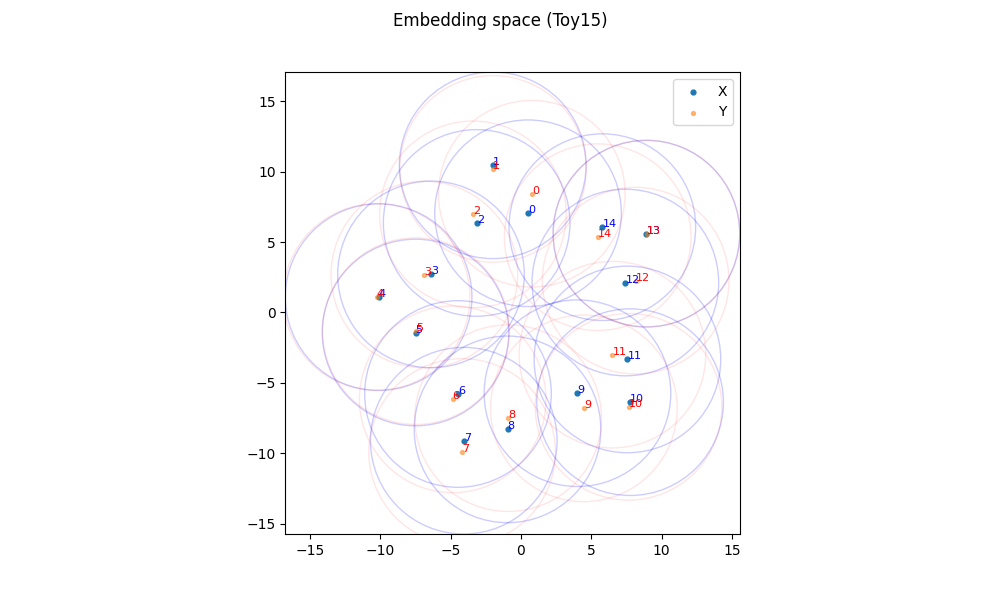

In [81]:
# scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_toy[:,0].numpy(), X_toy[:,1].numpy(), label='X', s=12)
plt.scatter(Y_toy[:,0].numpy(), Y_toy[:,1].numpy(), label='Y', s=8, alpha=0.5)

# Add number to each point
for i in range(X_toy.shape[0]):
    plt.text(X_toy[i,0], X_toy[i,1], str(i), fontsize=8, color='blue')

for i in range(Y_toy.shape[0]):
    plt.text(Y_toy[i,0], Y_toy[i,1], str(i), fontsize=8, color='red')


# plot circle around each point with radius beta
for i in range(X_toy.shape[0]):
    circle = plt.Circle((X_toy[i,0], X_toy[i,1]), beta_toy, color='blue', fill=False, alpha=0.2)

    plt.gcf().gca().add_artist(circle)

for i in range(Y_toy.shape[0]):
    circle = plt.Circle((Y_toy[i,0], Y_toy[i,1]), beta_toy, color='red', fill=False, alpha=0.1)

    plt.gcf().gca().add_artist(circle)

# x, y limits of the plot
x_min, x_max = X_toy[:,0].min().item(), X_toy[:,0].max().item()
y_min, y_max = X_toy[:,1].min().item(), X_toy[:,1].max().item()

plt.xlim(x_min-beta_toy, x_max+beta_toy)
plt.ylim(y_min-beta_toy, y_max+beta_toy)

# Make plot square
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle(f'Embedding space (Toy{toy_data_size})')
plt.legend()
plt.show()

